In [1]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [3]:
# Load YOLO model
weights_path = "yolov3.weights"  # Update with your path
config_path = "yolov3.cfg"       # Update with your path
names_path = "coco.names"        # Update with your path


# Load the network
net = cv2.dnn.readNet(weights_path, config_path)

# Get the output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

layer_names


('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

In [4]:
import fiftyone as fo
import fiftyone.zoo as foz

#
# Load 50 random samples from the validation split
#
# Only the required images will be downloaded (if necessary).
# By default, only detections are loaded
#


#
# Download the entire validation split and load both detections and
# segmentations
#
# Subsequent partial loads of the validation split will never require
# downloading any images


dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
)

# session = fo.launch_app(dataset)

Found annotations at 'C:\Users\prana\fiftyone\coco-2017\raw\instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [5]:
dataset.first()


<Sample: {
    'id': '67d3f2a934f505f341effe13',
    'media_type': 'image',
    'filepath': 'C:\\Users\\prana\\fiftyone\\coco-2017\\validation\\data\\000000000139.jpg',
    'tags': ['validation'],
    'metadata': <ImageMetadata: {

        'size_bytes': None,

        'mime_type': None,

        'width': 640,

        'height': 426,

        'num_channels': None,

    }>,
    'created_at': datetime.datetime(2025, 3, 14, 9, 11, 5, 401000),
    'last_modified_at': datetime.datetime(2025, 3, 14, 9, 11, 5, 401000),
    'ground_truth': <Detections: {

        'detections': [

            <Detection: {


                'id': '67d3f2a934f505f341effdff',


                'attributes': {},


                'tags': [],


                'label': 'potted plant',


                'bounding_box': [


                    0.37028125,


                    0.3345305164319249,


                    0.038593749999999996,


                    0.16314553990610328,


                ],


             

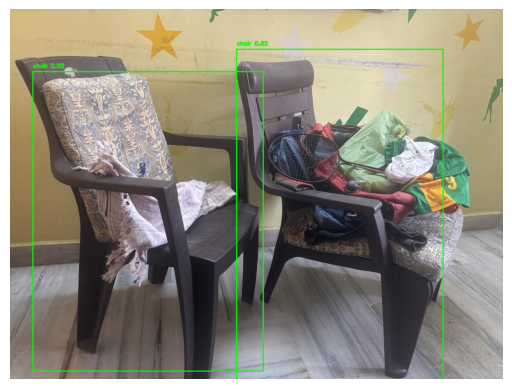

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_yolo_predictions(image_path, net, output_layers, classes):
    # Load image
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Run forward pass to get output of the output layers
    outputs = net.forward(output_layers)

    # Initialize lists to hold detected objects
    class_ids = []
    confidences = []
    boxes = []

    # Iterate over each detection
    for output in outputs:
        for detection in output:
            scores = detection[5:]  # Class probabilities
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.3:  # Lower threshold to detect more objects
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Get bounding box coordinates
                x = max(0, int(center_x - w / 2))
                y = max(0, int(center_y - h / 2))

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-max suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

    # Ensure indices is not empty before drawing
    if len(indices) > 0:
        for i in indices.flatten():  # Convert indices to a 1D array
            box = boxes[i]
            x, y, w, h = box
            label = classes[class_ids[i]]  # Get actual class name
            confidence = confidences[i]
            color = (0, 255, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

# Load YOLO model
weights_path = "yolov3.weights"  # Path to YOLO weights
config_path = "yolov3.cfg"  # Path to YOLO configuration file
net = cv2.dnn.readNet(weights_path, config_path)

# Define COCO class labels manually
classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster",
    "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"
]

# Get YOLO layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Example usage
image_path = 'temp.jpeg'  # Update with your image path
predicted_image = get_yolo_predictions(image_path, net, output_layers, classes)

# Convert image from BGR (OpenCV default) to RGB
predicted_image_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

plt.imshow(predicted_image_rgb)
plt.axis("off")  # Hide axes
plt.show()
